<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Longitudinal_Image_ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download 2D Slices of Dimentia Longitudina Data
Sagital Slices of the MRIs have been extracted from two time points. <br>
Original MRI can be found here: https://sites.wustl.edu/oasisbrains/home/oasis-2/<br>

Original label can be found here: https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers <br> or https://www.kaggle.com/datasets/abdelazizsami/oasis-longitudinal

In [ ]:
!gdown 1GAIX63ttx2eKg693KEiwki7MGqJBavPC
!unzip -q OAS2_Longitudinal.zip

Downloading...
From: https://drive.google.com/uc?id=1GAIX63ttx2eKg693KEiwki7MGqJBavPC
To: /content/OAS2_Longitudinal.zip
100% 13.1M/13.1M [00:00<00:00, 21.5MB/s]


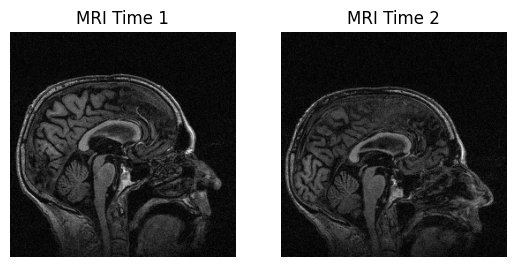

In [ ]:
import matplotlib.pyplot as plt
import cv2
img_t1 = cv2.imread('/content/OAS2_Longitudinal/OAS2_0001/OAS2_0001_MR1.png')
img_t2 = cv2.imread('/content/OAS2_Longitudinal/OAS2_0001/OAS2_0001_MR2.png')

plt.subplot(121); plt.axis('OFF');plt.title('MRI Time 1');plt.imshow(img_t1)
plt.subplot(122); plt.axis('OFF');plt.title('MRI Time 2');plt.imshow(img_t2)

#Prepare Datalaoder

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

class OASISLongitudinalDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with columns 'patient_id' and 'label'.
            root_dir (str): Directory containing patient folders with images.
            transform (callable, optional): Optional transform to be applied on images.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {"Nondemented": 0, "Demented": 1, "Converted": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Get patient_id and label
        patient_id = self.data.iloc[idx]['patient_id']
        label = self.data.iloc[idx]['label']
        label = self.label_map[label]
        label = torch.tensor(label, dtype=torch.long)

        # Construct paths to the two longitudinal images
        patient_dir = os.path.join(self.root_dir, patient_id)
        mri1_path = os.path.join(patient_dir, patient_id+'_MR1.png')
        mri2_path = os.path.join(patient_dir, patient_id+'_MR2.png')

        # Load images
        mri1 = Image.open(mri1_path).convert('RGB')
        mri2 = Image.open(mri2_path).convert('RGB')

        # Apply transforms if specified
        if self.transform:
            mri1 = self.transform(mri1)
            mri2 = self.transform(mri2)

        return {'patient_id': patient_id, 'label': label, 'MRI1': mri1, 'MRI2': mri2}

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

root_dir = '/content/OAS2_Longitudinal'
label_map_csv = '/content/OAS2_Longitudinal/oasis_longitudinal_label.csv'
dataset = OASISLongitudinalDataset(label_map_csv, root_dir, transform=transform)

#Spliting first 80% into training and remaining 20% into validation

# Calculate split indices
total_size = len(dataset)
train_size = int(0.8 * total_size)  # First 80%
val_size = total_size - train_size  # Remaining 20%

# Assign indices for training and validation
indices = list(range(total_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create Subset datasets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
print('Total Sample Size:', len(dataset), 'Training Sample:', len(train_dataset), 'Validation Sample:', len(val_dataset))

from collections import Counter
labels = [sample['label'].item() for sample in train_dataset]
print('Class Frequency in Training Set:', Counter(labels))

labels = [sample['label'].item() for sample in val_dataset]
print('Class Frequency in Validation Set:', Counter(labels))


Total Sample Size: 150 Training Sample: 120 Validation Sample: 30
Class Frequency in Training Set: Counter({0: 58, 1: 49, 2: 13})
Class Frequency in Validation Set: Counter({1: 15, 0: 14, 2: 1})


LSTM Model Architecture using Pytorch:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvLSTMClassifier(nn.Module):
    def __init__(self, input_channels, hidden_dim, num_classes=None):
        super(ConvLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(32 * 128 * 128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape
        x = x.view(batch_size * seq_len, channels, height, width)

        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # Reshape for LSTM
        x = x.view(batch_size, seq_len, -1)

        # LSTM
        x, _ = self.lstm(x)

        # Fully connected layer (classification)
        x = x[:, -1, :]  # Use the last time step
        x = self.fc(x)
        return x

Training:

In [ ]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(12)

# Initialize the dataset and dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_channels = 3  # RGB images
hidden_dim = 128
num_classes = 3  # Binary classification (Demented/Nondemented)
learning_rate = 0.0001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss function, and optimizer
model = ConvLSTMClassifier(input_channels, hidden_dim, num_classes=num_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_path = "best_model.pth"
best_epoch = 0
best_accuracy = 0

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
        inputs = torch.stack([mri1, mri2], dim=1)  # Shape: [batch_size, seq_len, channels, height, width]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(outputs.shape, labels.shape)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
            inputs = torch.stack([mri1, mri2], dim=1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # print(labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # print('predicted:', predicted)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total

    # Save the best model
    if accuracy > best_accuracy:
        best_val_loss = val_loss
        # torch.save(model.state_dict(), best_model_path)
        best_epoch = epoch
        best_accuracy = accuracy
        print(f"New best model saved with validation loss: {val_loss:.4f}, Acc:{best_accuracy:.4f}")

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
      f"Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, "
      f"Best Epoch: {best_epoch}, Best Acc: {best_accuracy:.4f}")



New best model saved with validation loss: 0.8547, Acc:0.5000
Epoch [1/30], Train Loss: 1.0080, Val Loss: 0.8547, Accuracy: 0.5000, Best Epoch: 0, Best Acc: 0.5000
Epoch [2/30], Train Loss: 0.9503, Val Loss: 0.8556, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.5000
Epoch [3/30], Train Loss: 0.9576, Val Loss: 0.8687, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.5000
Epoch [4/30], Train Loss: 0.9246, Val Loss: 0.8458, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.5000
New best model saved with validation loss: 0.8468, Acc:0.5333
Epoch [5/30], Train Loss: 0.8521, Val Loss: 0.8468, Accuracy: 0.5333, Best Epoch: 4, Best Acc: 0.5333
Epoch [6/30], Train Loss: 0.8086, Val Loss: 0.8629, Accuracy: 0.4667, Best Epoch: 4, Best Acc: 0.5333
Epoch [7/30], Train Loss: 0.7319, Val Loss: 0.9152, Accuracy: 0.4667, Best Epoch: 4, Best Acc: 0.5333
New best model saved with validation loss: 0.7894, Acc:0.7000
Epoch [8/30], Train Loss: 0.6547, Val Loss: 0.7894, Accuracy: 0.7000, Best Epoch: 7, Best Acc: 0.700

#LSTM Model Architecture From Scratch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Weight matrices
        self.W_i = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.W_f = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.W_o = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.W_g = nn.Linear(input_dim + hidden_dim, hidden_dim)

    def forward(self, x, hidden_state):
        h_prev, c_prev = hidden_state  # Previous hidden and cell states

        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=1)

        # Compute LSTM gates
        i_t = torch.sigmoid(self.W_i(combined))  # Input gate
        f_t = torch.sigmoid(self.W_f(combined))  # Forget gate
        o_t = torch.sigmoid(self.W_o(combined))  # Output gate
        g_t = torch.tanh(self.W_g(combined))    # Candidate cell state

        # Update cell state
        c_next = f_t * c_prev + i_t * g_t

        # Compute new hidden state
        h_next = o_t * torch.tanh(c_next)

        return h_next, c_next

class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_first=True):
        super(CustomLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_first = batch_first
        self.cell = CustomLSTMCell(input_dim, hidden_dim)

    def forward(self, x, hidden_state=None):
        if self.batch_first:
            batch_size, seq_len, _ = x.size()
        else:
            seq_len, batch_size, _ = x.size()

        # Initialize hidden and cell states if not provided
        if hidden_state is None:
            h = torch.zeros(batch_size, self.hidden_dim, device=x.device)
            c = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        else:
            h, c = hidden_state

        outputs = []
        for t in range(seq_len):
            # Select the appropriate time step
            x_t = x[:, t, :] if self.batch_first else x[t, :, :]

            # Pass through LSTM cell
            h, c = self.cell(x_t, (h, c))

            # Store output
            outputs.append(h)

        # Stack outputs
        outputs = torch.stack(outputs, dim=1 if self.batch_first else 0)

        return outputs, (h, c)

class ConvCustomLSTMClassifier(nn.Module):
    def __init__(self, input_channels, hidden_dim, num_classes=None):
        super(ConvCustomLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Replace nn.LSTM with CustomLSTM
        self.lstm = CustomLSTM(32 * 128 * 128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape
        x = x.view(batch_size * seq_len, channels, height, width)

        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # Reshape for LSTM
        x = x.view(batch_size, seq_len, -1)

        # Custom LSTM
        x, _ = self.lstm(x)

        # Fully connected layer (classification)
        x = x[:, -1, :]  # Use the last time step
        x = self.fc(x)
        return x



Training on custom LSTM model:

In [ ]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(12)

# Initialize the dataset and dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_channels = 3  # RGB images
hidden_dim = 128
num_classes = 3  # Binary classification (Demented/Nondemented)
learning_rate = 0.0001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss function, and optimizer
model = ConvCustomLSTMClassifier(input_channels, hidden_dim, num_classes=num_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_path = "best_model.pth"
best_epoch = 0
best_accuracy = 0

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
        inputs = torch.stack([mri1, mri2], dim=1)  # Shape: [batch_size, seq_len, channels, height, width]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(outputs.shape, labels.shape)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
            inputs = torch.stack([mri1, mri2], dim=1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # print(labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # print('predicted:', predicted)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total

    # Save the best model
    if accuracy > best_accuracy:
        best_val_loss = val_loss
        # torch.save(model.state_dict(), best_model_path)
        best_epoch = epoch
        best_accuracy = accuracy
        print(f"New best model saved with validation loss: {val_loss:.4f}, Acc:{best_accuracy:.4f}")

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
      f"Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, "
      f"Best Epoch: {best_epoch}, Best Acc: {best_accuracy:.4f}")



New best model saved with validation loss: 0.8932, Acc:0.4667
Epoch [1/30], Train Loss: 0.9855, Val Loss: 0.8932, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.4667
Epoch [2/30], Train Loss: 0.9589, Val Loss: 0.8841, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.4667
Epoch [3/30], Train Loss: 0.9425, Val Loss: 0.8776, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.4667
Epoch [4/30], Train Loss: 0.9160, Val Loss: 0.8806, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.4667
New best model saved with validation loss: 0.8461, Acc:0.5000
Epoch [5/30], Train Loss: 0.8790, Val Loss: 0.8461, Accuracy: 0.5000, Best Epoch: 4, Best Acc: 0.5000
Epoch [6/30], Train Loss: 0.8394, Val Loss: 0.8643, Accuracy: 0.4667, Best Epoch: 4, Best Acc: 0.5000
Epoch [7/30], Train Loss: 0.8278, Val Loss: 0.8282, Accuracy: 0.5000, Best Epoch: 4, Best Acc: 0.5000
Epoch [8/30], Train Loss: 0.7680, Val Loss: 0.8437, Accuracy: 0.4667, Best Epoch: 4, Best Acc: 0.5000
New best model saved with validation loss: 0.8215, Acc:0.533